In [71]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

# Data Preprocessing

In [17]:
# Downloading  Dataset (Google Stocks) using yfinance
ticker = 'GOOGL'
data = yf.download(ticker, start="2010-01-01", end="2024-1-1", progress=False)

df = pd.DataFrame(data)
df.to_csv('stock.csv')

'''
Note that some extras columns were added. Delete those columns manually.
And Changing Name of Price column to Date
'''

'\nNote that some extras columns were added. Delete those columns manually.\nAnd Changing Name of Price column to Date\n'

In [72]:
# Load dataset
df = pd.read_csv('stock.csv')

# Calculating these for inverse minmax scaler
min_val = df['Close'].min()
max_val = df['Close'].max()

In [73]:
df.head()

Date  Adj Close      Close       High        Low       Open  \
0  2010-01-04  15.627782  15.684434  15.753504  15.621622  15.689439   
1  2010-01-05  15.558963  15.615365  15.711712  15.554054  15.695195   
2  2010-01-06  15.166741  15.221722  15.662162  15.174174  15.662162   
3  2010-01-07  14.813667  14.867367  15.265265  14.831081  15.250250   
4  2010-01-08  15.011149  15.065566  15.096346  14.742492  14.814815   

      Volume  
0   78169752  
1  120067812  
2  158988852  
3  256315428  
4  188783028

In [74]:
def compute_rsi(data, window=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['RSI'] = compute_rsi(df)

def compute_macd(data):
    short_ema = data['Close'].ewm(span=12, adjust=False).mean()
    long_ema = data['Close'].ewm(span=26, adjust=False).mean()
    macd = short_ema - long_ema
    signal = macd.ewm(span=9, adjust=False).mean()
    return macd, signal

df['MACD'], df['MACD_signal'] = compute_macd(df)

def compute_bollinger_bands(data, window=20, num_std=2):
    rolling_mean = data['Close'].rolling(window=window).mean()
    rolling_std = data['Close'].rolling(window=window).std()
    upper_bb = rolling_mean + (rolling_std * num_std)
    lower_bb = rolling_mean - (rolling_std * num_std)
    return upper_bb, lower_bb

df['UpperBB'], df['LowerBB'] = compute_bollinger_bands(df)

In [75]:
df = df.drop(['Date'], axis=1)  


scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

scaled_df = pd.DataFrame(scaled_data, columns=df.columns)

In [76]:
scaled_df.dropna(inplace=True)

In [77]:
scaled_df.head()

Adj Close     Close      High       Low      Open    Volume       RSI  \
19   0.017464  0.017464  0.016662  0.017524  0.017177  0.138281  0.137007   
20   0.017122  0.017122  0.016510  0.017037  0.017242  0.264750  0.154088   
21   0.018869  0.018869  0.017782  0.017149  0.016119  0.189564  0.242807   
22   0.016340  0.016340  0.017052  0.016665  0.017605  0.215510  0.187682   
23   0.017152  0.017152  0.016250  0.016103  0.016071  0.200316  0.243991   

        MACD  MACD_signal   UpperBB   LowerBB  
19  0.451095     0.456723  0.026661  0.016413  
20  0.450611     0.454109  0.025523  0.015825  
21  0.452763     0.452498  0.024099  0.015772  
22  0.452321     0.451111  0.023259  0.015132  
23  0.453473     0.450258  0.022662  0.014586

# Correlations Matrix Using Seaborn

In [25]:
corr = df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".4f")
plt.title("Correlation Matrix")
plt.show()

# Samples X and Label Y

In [26]:
window_size = 30
predict_days = 5

x = []
y = []

if len(scaled_df) > window_size + predict_days - 1:
    for i in range(len(scaled_df) - window_size - predict_days + 1):
        x.append(scaled_df.iloc[i:i+window_size].drop("Close", axis=1).values)  # Drop 'Close' to use as input
        y.append(scaled_df.iloc[i+window_size:i+window_size+predict_days]["Close"].values)

x = np.array(x)
y = np.array(y)

# Output results
print(f"x shape: {x.shape}")  
print(f"y shape: {y.shape}")

x shape: (3469, 30, 10)
y shape: (3469, 5)


# Train / Test Split

In [27]:
train_size = int(len(x) * 0.8)  # 80% for training
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Transformer Architecture

In [56]:
import tensorflow as tf
import numpy as np

# Positional Encoding
def positional_encoding(position, d_model):
    angle_rads = np.arange(position)[:, np.newaxis] * np.arange(d_model)[np.newaxis, :] / np.power(10000, (2 * (np.arange(d_model)[np.newaxis, :] // 2)) / d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])  # Apply sin to even indices
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])  # Apply cos to odd indices
    return tf.cast(angle_rads, dtype=tf.float32)

# Transformer Block
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout_rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(ff_dim, activation='relu'), 
            tf.keras.layers.Dense(embed_dim)
        ])
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Model Definition
def create_transformer(input_shape, num_heads, embed_dim, ff_dim, num_blocks, dropout_rate=0.1):
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Dense(embed_dim)(inputs)
    
    # Apply positional encoding
    x += positional_encoding(input_shape[0], embed_dim)
    
    # Apply multiple transformer blocks
    for _ in range(num_blocks):
        x = TransformerBlock(embed_dim, num_heads, ff_dim, dropout_rate)(x)
    
    # Use GlobalAveragePooling1D to reduce sequence dimension
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    
    # Fully connected layer and dropout for regularization
    x = tf.keras.layers.Dense(128, activation="relu")(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    
    # Output layer: single unit for predicting future stock price
    outputs = tf.keras.layers.Dense(5)(x)  
    return tf.keras.Model(inputs=inputs, outputs=outputs)

# Model Hyperparameters
num_features = 10
input_shape = (window_size, num_features) 
num_heads = 4
embed_dim = 64
ff_dim = 128
num_blocks = 2
dropout_rate = 0.1

# Create the model
model = create_transformer(input_shape, num_heads, embed_dim, ff_dim, num_blocks, dropout_rate)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.000007), loss="mse", metrics=["mae"])

# Print model summary
model.summary()


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 30, 10)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 30, 64)         │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ add_2 (Add)                     │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_4             │ (None, 30, 64)         │        83,200 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_5             │ (None, 30, 64)         │        83,200 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 176,069 (687.77 KB)

 Trainable params: 176,069 (687.77 KB)

 Non-trainable params: 0 (0.00 B)

# Training

In [57]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=150, batch_size=32)

Epoch 1/150
87/87 ━━━━━━━━━━━━━━━━━━━━ 20s 103ms/step - loss: 0.6493 - mae: 0.6247 - val_loss: 1.1654 - val_mae: 0.8929
Epoch 2/150
87/87 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - loss: 0.1913 - mae: 0.3357 - val_loss: 0.6716 - val_mae: 0.7162
Epoch 3/150
87/87 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - loss: 0.0621 - mae: 0.1917 - val_loss: 0.4694 - val_mae: 0.6180
Epoch 4/150
87/87 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step - loss: 0.0408 - mae: 0.1568 - val_loss: 0.3772 - val_mae: 0.5593
Epoch 5/150
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 0.0324 - mae: 0.1397 - val_loss: 0.3140 - val_mae: 0.5098
Epoch 6/150
87/87 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - loss: 0.0285 - mae: 0.1323 - val_loss: 0.2671 - val_mae: 0.4703
Epoch 7/150
87/87 ━━━━━━━━━━━━━━━━━━━━ 9s 98ms/step - loss: 0.0260 - mae: 0.1251 - val_loss: 0.2242 - val_mae: 0.4290
Epoch 8/150
87/87 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - loss: 0.0237 - mae: 0.1204 - val_loss: 0.1942 - val_mae: 0.3974
Epoch 9/150
87/87 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step

In [58]:
y_pred = model.predict(x_test)

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step 


## MinMaxScaler Inverse

In [59]:
y_pred_original = y_pred * (max_val - min_val) + min_val


In [60]:
y = y_test.copy()
y_original = y * (max_val - min_val) + min_val


# Mean Absolute Error

In [61]:
import matplotlib.pyplot as plt

plt.plot(history.history['mae'], label='MAE', color='g')
plt.plot(history.history['val_mae'], label='Val MAE', color='r')
plt.legend()
plt.show()

# Recent 30 Days

In [62]:
x_test.shape

(694, 30, 10)

In [63]:
a, b, c, d, e, f = x_test[-6], x_test[-11], x_test[-16], x_test[-21], x_test[-26], x_test[-31]

a = np.expand_dims(a, axis=0)
b = np.expand_dims(b, axis=0)
c = np.expand_dims(c, axis=0)
d = np.expand_dims(d, axis=0)
e = np.expand_dims(e, axis=0)
f = np.expand_dims(f, axis=0)

In [64]:
p1 = model.predict(a)
p2 = model.predict(b)
p3 = model.predict(c)
p4 = model.predict(d)
p5 = model.predict(e)
p6 = model.predict(f)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


In [65]:
pa = p1[0] * (max_val - min_val) + min_val
pb = p2[0] * (max_val - min_val) + min_val
pc = p3[0] * (max_val - min_val) + min_val
pd = p4[0] * (max_val - min_val) + min_val
pe = p5[0] * (max_val - min_val) + min_val
pf = p1[0] * (max_val - min_val) + min_val

In [66]:
result = np.concatenate((pa.flatten(), pb.flatten(), pc.flatten(), pd.flatten(), pe.flatten(), pf.flatten()))

In [67]:
result.shape

(30,)

epoch      loss
0      1  0.151902
1      2  0.055815
2      3  0.039475
3      4  0.032995
4      5  0.027762

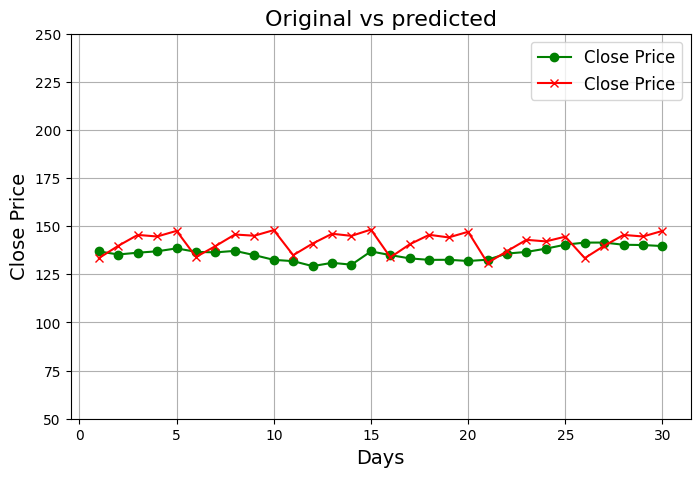

In [78]:
# Plot the data
plt.figure(figsize=(8, 5))
plt.plot(range(1, 31), df['Close'].tail(30), marker="o", label="Close Price", color='g')
plt.plot(range(1, 31), result, marker="x", label="Close Price", color='r')
plt.title("Original vs predicted", fontsize=16)
plt.xlabel("Days", fontsize=14)
plt.ylabel("Close Price", fontsize=14)
plt.ylim((50, 250))
plt.grid(True)
plt.legend(fontsize=12)
plt.show()

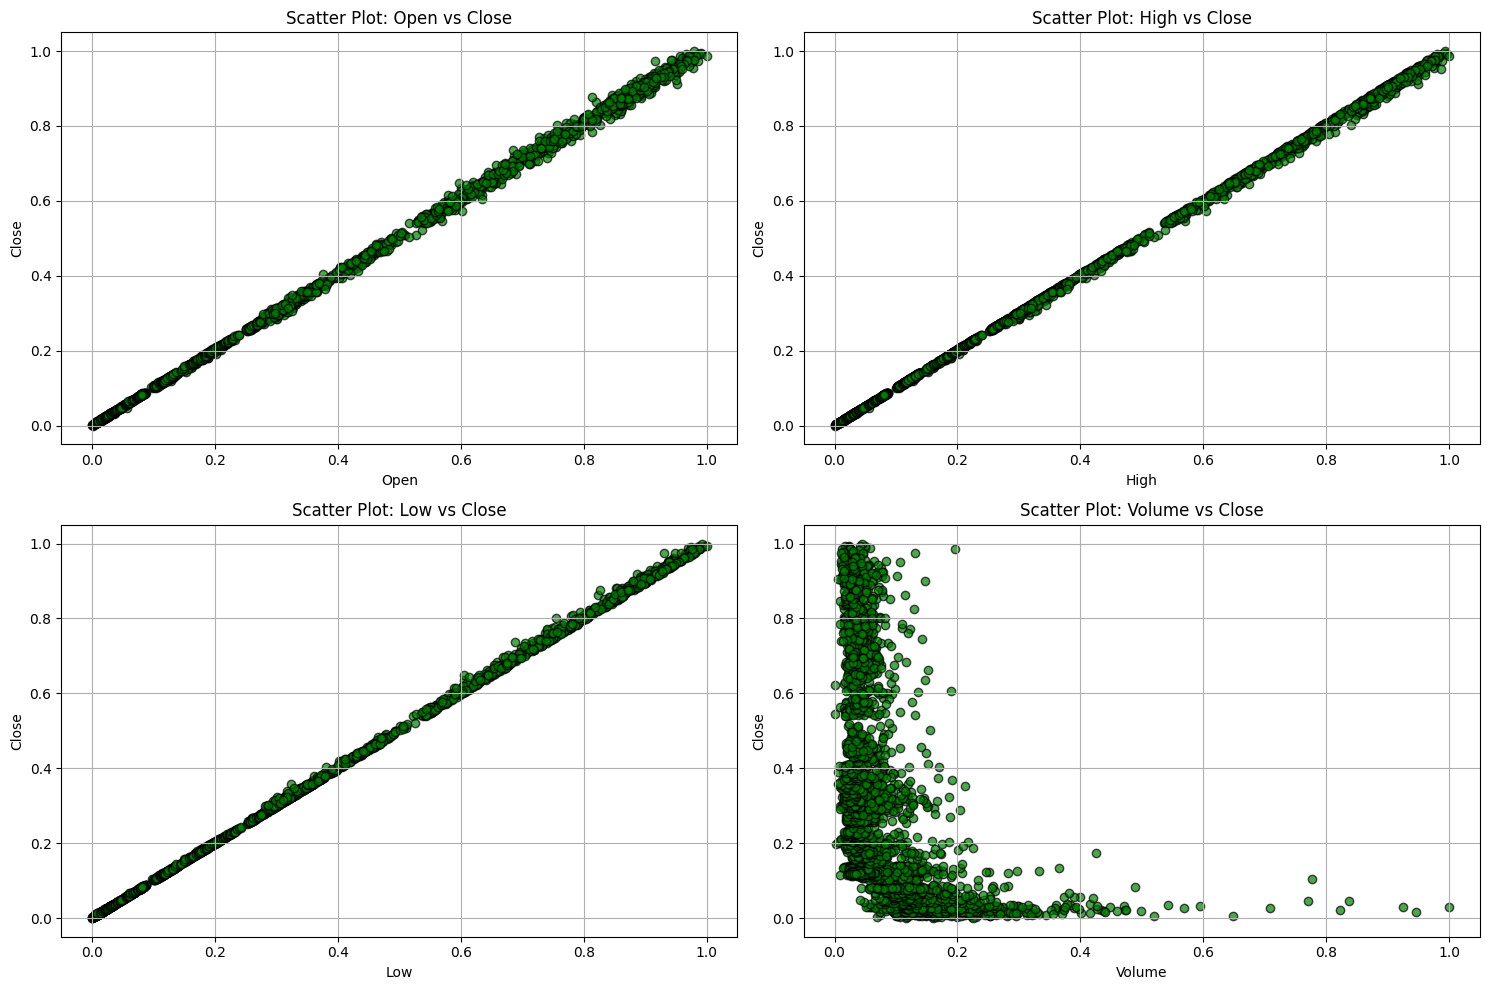

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

features = ['Open', 'High', 'Low', 'Volume']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(features):
    plt.subplot(2, 2, i + 1)
    plt.scatter(scaled_df[feature], scaled_df["Close"], alpha=0.7, edgecolor='k', color='g')
    plt.title(f"Scatter Plot: {feature} vs Close")
    plt.xlabel(feature)
    plt.ylabel("Close")
    plt.grid(True)

plt.tight_layout()
plt.show()


In [79]:
df = pd.DataFrame({
    'Days': range(1, 31),
    'Original': df['Close'].tail(30),
    'Predicted': result
})

df.to_csv('org_vs_pred am.csv', index=False)

history_dict = history.history

# Create a DataFrame from the history
df = pd.DataFrame({
    'epoch': range(1, len(history_dict['loss']) + 1),
    'train_loss': history_dict['loss'],
    'val_loss': history_dict['val_loss']
})

# Save the DataFrame to a CSV file
df.to_csv('epochs_vs_loss am.csv', index=False)